In [1]:
import numpy as np 
import cv2
import easyocr
import matplotlib.pyplot as plt
import os
import torch
from torchvision import transforms
from PIL import Image
from ultralytics import YOLO

In [8]:

# core_models
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Tuple, Union
import numpy as np


@dataclass
class Detection:
    bbox : Tuple[int , int , int , int ] # (x1, y1, x2, y2)
    class_id : int
    class_name : str
    confidence : float
    tracker_id : Optional[int] = None

@dataclass
class ViolationEvent:
    timestamp : float
    tracker_id : int
    detection : list[Detection]
    violation_type : str 
    frame : np.ndarray


@dataclass 
class DetectionConfig:
    model_path : str
    confidence_threshold : float = 0.5
    nms_threshold : float = 0.4
    input_size : tuple[int , int] = (640, 640)
    device : Optional[str] = 'cpu'



In [9]:
# test 
det = Detection(
    bbox=(100, 200, 300, 400),
    class_id=2,
    class_name='no-helmet',
    confidence=0.85,
    tracker_id=5
)
print(det)

Detection(bbox=(100, 200, 300, 400), class_id=2, class_name='no-helmet', confidence=0.85, tracker_id=5)


## Configureation 


In [12]:
from pathlib import Path
from typing import Dict, Any
import yaml

@dataclass
class Config:
    """Global configuration manager"""
    
    # Paths
    PROJECT_ROOT = Path("ATV")
    WEIGHTS_DIR = PROJECT_ROOT /"training/train5/weights"
    EVIDENCE_DIR = PROJECT_ROOT / "database/evidence"
    
    # Model Settings
    MODEL_PATH = WEIGHTS_DIR / 'best.onnx'
    CONF_THRESHOLD = 0.5
    IOU_THRESHOLD = 0.4
    INPUT_SIZE = (640, 640)
    
    # Classes
    CLASSES = ['bike', 'helmet', 'no-helmet', 'number-plate']
    
    # Tracking
    TRACKER_CACHE_TTL = 10.0  # seconds
    
    # Database
    DB_PATH = PROJECT_ROOT / "database/violations.db"
    


In [13]:
print(Config.MODEL_PATH)
print(Config.CLASSES)

ATV/training/train5/weights/best.onnx
['bike', 'helmet', 'no-helmet', 'number-plate']


## Onnx runtime validation ( testinG)

In [20]:
import sys
import os

sys.path.append(os.path.abspath(".."))  

import onnxruntime as ort
from config.config import Config
model_path = Config.MODEL_PATH
session = ort.InferenceSession(str(model_path))
print(session.get_inputs()[0].name)
print(session.get_outputs()[0].name)
print(session.get_providers())



images
output0
['CPUExecutionProvider']


Original image shape: (720, 540, 3)
Preprocessed image shape (with batch): (1, 3, 640, 640)
Scale ratio: 0.8888888888888888
Resized dimensions: 480 640


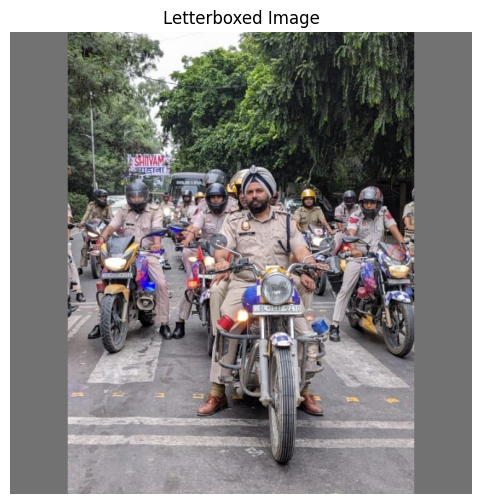

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

class Config:
    IMG_SIZE = 640  

class CoreEngine:
    def __init__(self):
        self.img_size = Config.IMG_SIZE

    def preprocess(self, img):
        
        original_height, original_width = img.shape[:2]
        target_height, target_width = self.img_size, self.img_size

        # Scale ratio
        scale_ratio = min(target_height / original_height, target_width / original_width)

        # Resize dimensions (before padding)
        resized_width = int(round(original_width * scale_ratio))
        resized_height = int(round(original_height * scale_ratio))

        # Compute padding
        pad_width = target_width - resized_width
        pad_height = target_height - resized_height
        pad_left = pad_width / 2
        pad_right = pad_width / 2
        pad_top = pad_height / 2
        pad_bottom = pad_height / 2

        # Resize if needed
        if (original_width, original_height) != (resized_width, resized_height):
            img = cv2.resize(img, (resized_width, resized_height), interpolation=cv2.INTER_LINEAR)

        # Add padding (letterbox)
        top = int(round(pad_top - 0.1))
        bottom = int(round(pad_bottom + 0.1))
        left = int(round(pad_left - 0.1))
        right = int(round(pad_right + 0.1))
        img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(114, 114, 114))

        # Convert to CHW, RGB, contiguous
        img = img.transpose(2, 0, 1)[::-1]
        img = np.ascontiguousarray(img)

        # Float & normalize
        img = img.astype(np.float32) / 255.0

        # Add batch dimension
        img = img[None]

        return img, scale_ratio, (resized_width, resized_height)

# -------------------
# TESTING CODE FOR NOTEBOOK
# -------------------

# Load an image (replace 'test.jpg' with your file path)
image_path = "/home/machine/ATV/img11.jpeg"
img = cv2.imread(image_path)

if img is None:
    print(f"Failed to load image: {image_path}")
else:
    engine = CoreEngine()
    preprocessed_img, scale, (w, h) = engine.preprocess(img)

    print("Original image shape:", img.shape)
    print("Preprocessed image shape (with batch):", preprocessed_img.shape)
    print("Scale ratio:", scale)
    print("Resized dimensions:", w, h)

    # Display the padded image inline
    # Convert CHW RGB back to HWC BGR for visualization
    display_img = (preprocessed_img[0][::-1].transpose(1, 2, 0) * 255).astype(np.uint8)
    
    plt.figure(figsize=(6,6))
    plt.imshow(display_img[..., ::-1])  # convert BGR to RGB for matplotlib
    plt.title("Letterboxed Image")
    plt.axis("off")
    plt.show()
